粤港澳大湾区数据分析 - 第六章：降维与因子分析

1. 创建示例数据...
2. 数据预处理...
3. 初始化分析器...
数据概况：11个城市，14个变量

4. 执行主成分分析...
正在进行主成分分析...


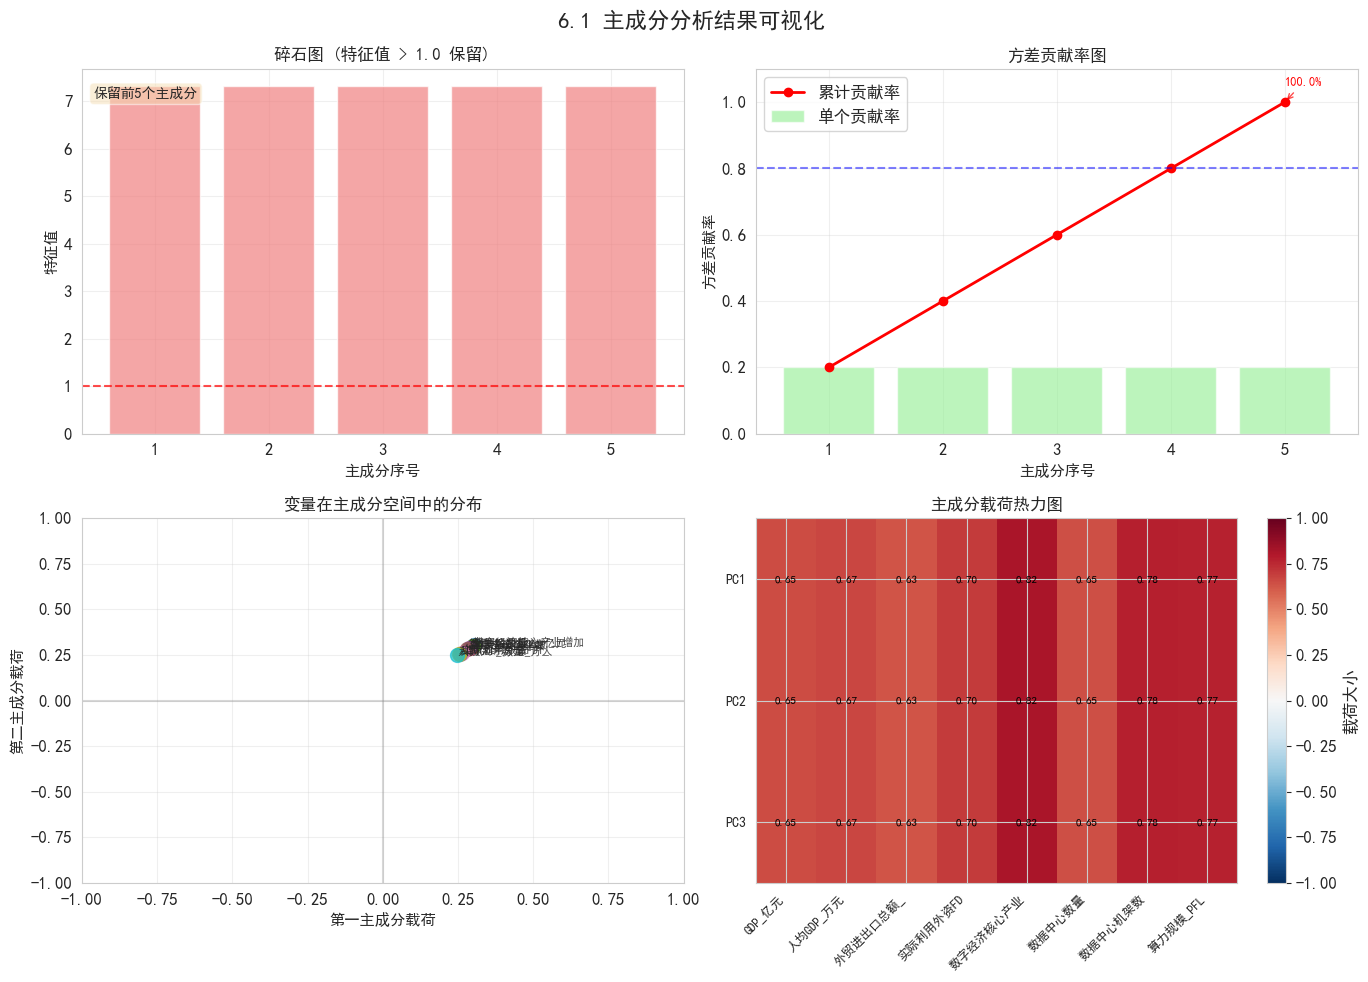

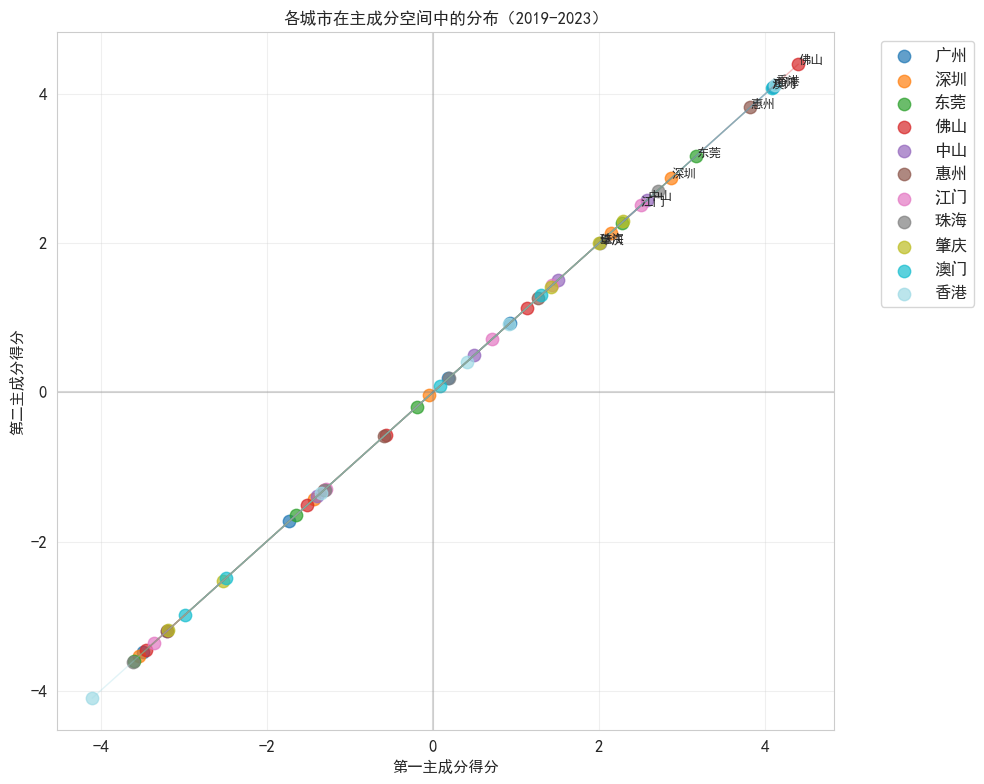


5. 执行因子分析...
正在进行因子分析...


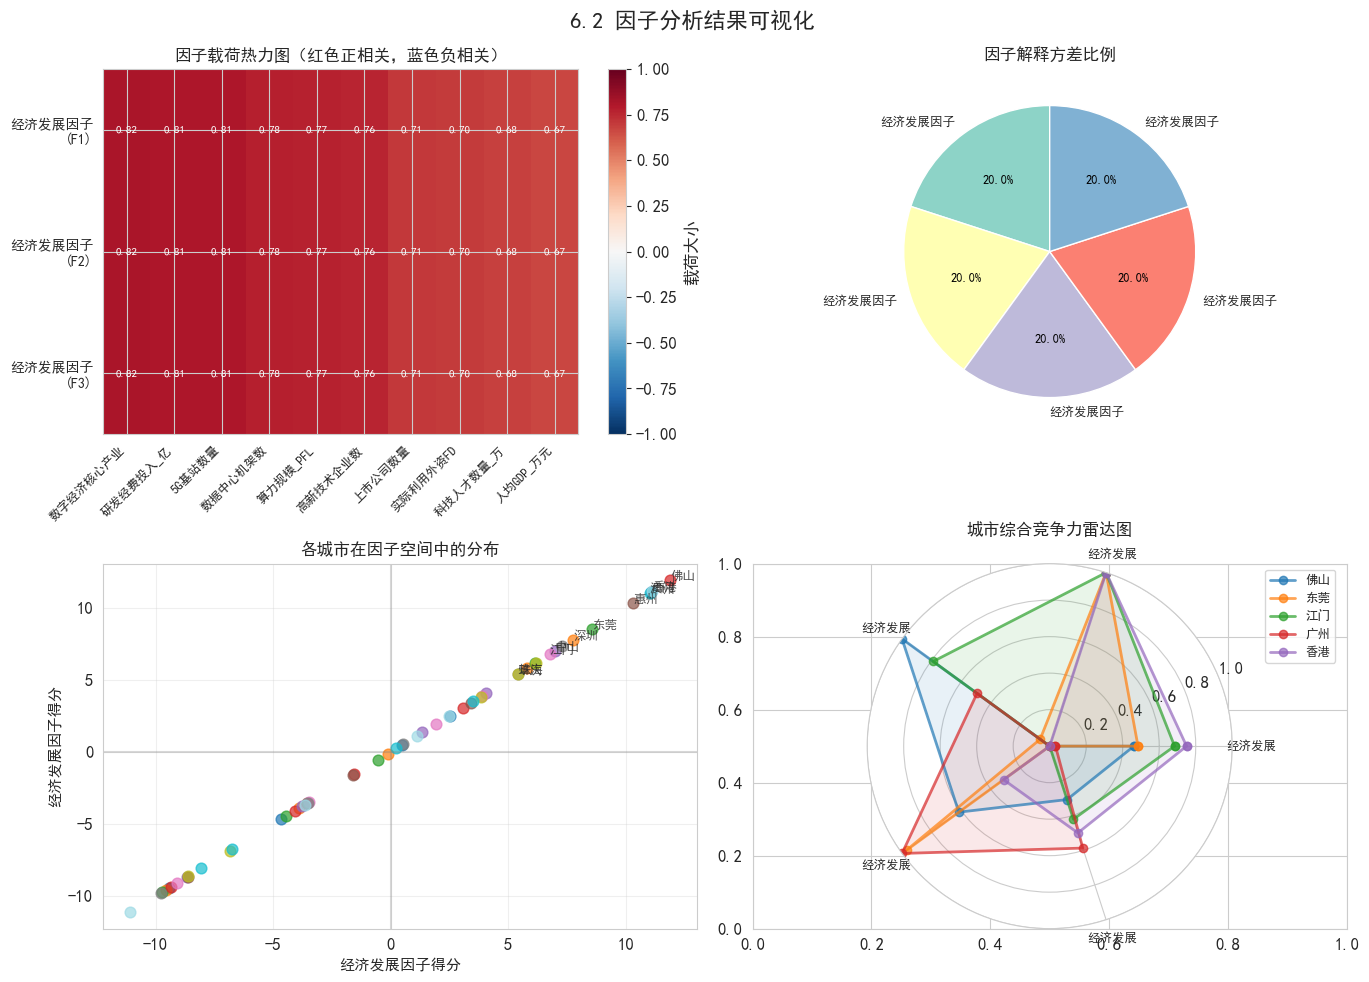

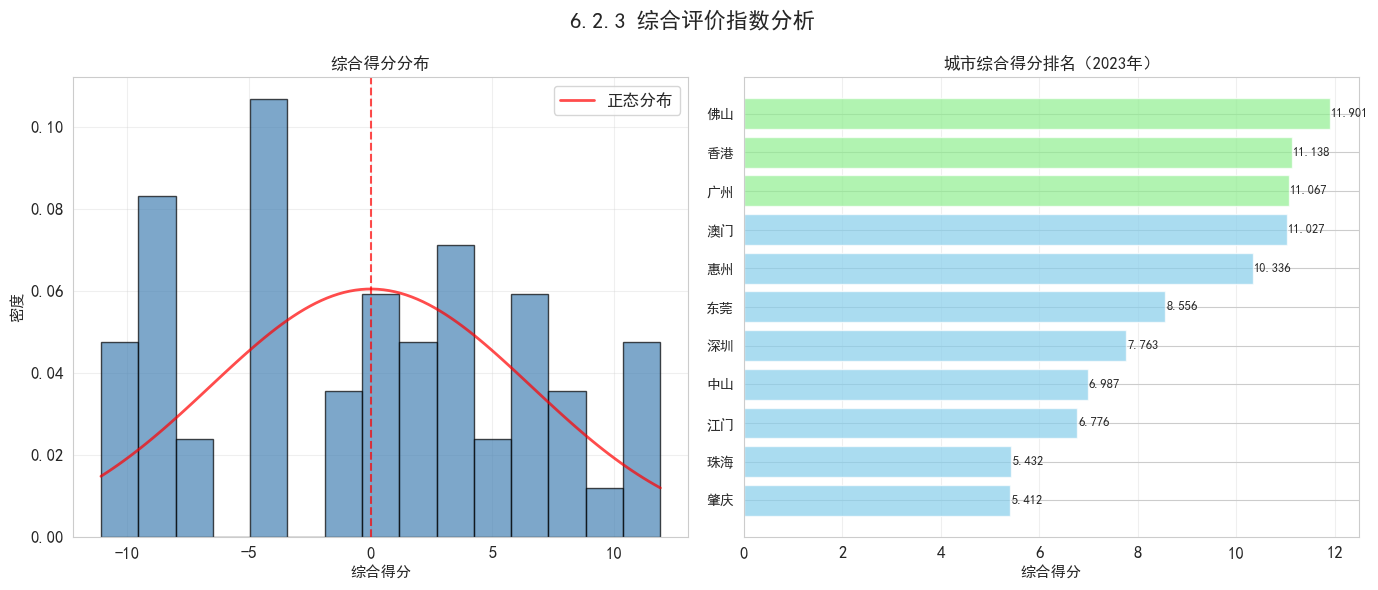


6. 创建方法对比图...


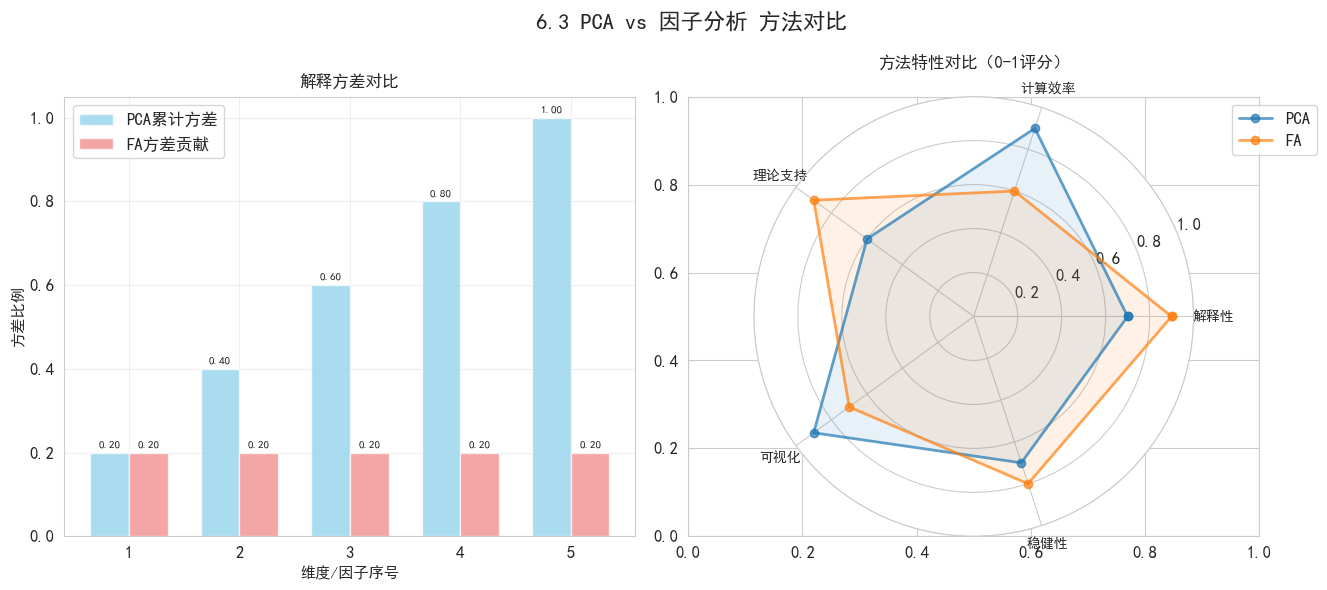


分析完成！


In [33]:
import math
import random
import statistics
import copy
from typing import List, Dict, Any, Tuple, Optional
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np

# 设置中文字体
plt.rcParams['font.sans-serif'] = ['SimHei', 'Microsoft YaHei', 'DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False

# ==================== 第四章：数据预处理（简化版）====================
def create_sample_data() -> Dict[str, Any]:
    """创建示例数据"""
    cities = ["广州", "深圳", "东莞", "佛山", "中山", "惠州", "江门", "珠海", "肇庆", "澳门", "香港"]
    
    # 定义变量分类
    categories = {
        "经济指标": ["GDP_亿元", "人均GDP_万元", "外贸进出口总额_亿元", "实际利用外资FDI_亿美元"],
        "数字经济": ["数字经济核心产业增加值_亿元", "数据中心数量", "数据中心机架数", "算力规模_PFLOPS", "5G基站数量"],
        "科技创新": ["研发经费投入_亿元", "发明专利授权量", "高新技术企业数", "科技人才数量_万人", "上市公司数量"]
    }
    
    city_data = {}
    for city in cities:
        metrics = {"年份": [2019, 2020, 2021, 2022, 2023]}
        
        # 为每个指标生成数据
        for category, indicators in categories.items():
            for indicator in indicators:
                # 为每个城市设置不同的基础值
                base_value = random.uniform(50, 500) * (1 + cities.index(city)/10)
                
                # 生成5年数据，有增长趋势
                values = []
                for year_idx in range(5):
                    growth = 1.05 + random.uniform(-0.05, 0.1)  # 年增长约5-15%
                    value = base_value * (growth ** year_idx)
                    value *= random.uniform(0.9, 1.1)  # 随机波动
                    
                    # 为一些城市添加异常值
                    if city == "广州" and indicator == "GDP_亿元" and year_idx == 2:
                        value *= 1.5  # 异常高值
                    elif city == "深圳" and indicator == "发明专利授权量" and year_idx == 3:
                        value *= 0.6  # 异常低值
                    
                    values.append(round(value, 2))
                
                metrics[indicator] = values
        
        city_data[city] = metrics
    
    return {"city_data": city_data}

def preprocess_and_normalize(data: Dict[str, Any]) -> Dict[str, Any]:
    """预处理和标准化数据"""
    cleaned_data = copy.deepcopy(data)
    
    for city, metrics in cleaned_data.get("city_data", {}).items():
        # 标准化每个指标
        for indicator, values in list(metrics.items()):
            if indicator != "年份":
                # 简单的z-score标准化
                if len(values) > 1:
                    mean_val = statistics.mean(values)
                    std_val = statistics.stdev(values)
                    if std_val > 0:
                        normalized = [(v - mean_val) / std_val for v in values]
                        metrics[f"{indicator}_norm"] = normalized
    
    return cleaned_data

# ==================== 第六章：降维与因子分析（图形化版）====================
class DimensionalityReductionAnalysis:
    """降维与因子分析类，专注于图形展示"""
    
    def __init__(self, cleaned_data: Dict[str, Any]):
        self.cleaned_data = cleaned_data
        self.cities = list(cleaned_data.get("city_data", {}).keys())
        self.var_names = []
        self.data_matrix = []
        self.pca_results = {}
        self.fa_results = {}
        
        self._prepare_data()
    
    def _prepare_data(self):
        """准备分析数据"""
        if not self.cleaned_data.get("city_data"):
            return
        
        # 获取所有标准化变量
        first_city = self.cities[0]
        for var_name in self.cleaned_data["city_data"][first_city]:
            if var_name.endswith("_norm"):
                self.var_names.append(var_name.replace("_norm", ""))
        
        # 构建数据矩阵（城市×年份，变量）
        years = self.cleaned_data["city_data"][first_city]["年份"]
        for city in self.cities:
            for year_idx in range(len(years)):
                row = []
                for var in self.var_names:
                    orig_var = f"{var}_norm"
                    if orig_var in self.cleaned_data["city_data"][city]:
                        values = self.cleaned_data["city_data"][city][orig_var]
                        if year_idx < len(values):
                            row.append(values[year_idx])
                        else:
                            row.append(0)
                    else:
                        row.append(0)
                self.data_matrix.append(row)
    
    def _correlation_matrix(self, data: List[List[float]]) -> List[List[float]]:
        """计算相关系数矩阵"""
        n = len(data[0])
        corr_matrix = [[0.0] * n for _ in range(n)]
        
        for i in range(n):
            for j in range(i, n):
                var_i = [row[i] for row in data]
                var_j = [row[j] for row in data]
                
                mean_i = statistics.mean(var_i)
                mean_j = statistics.mean(var_j)
                
                numerator = sum((xi - mean_i) * (xj - mean_j) for xi, xj in zip(var_i, var_j))
                denominator = math.sqrt(sum((xi - mean_i) ** 2 for xi in var_i)) * \
                            math.sqrt(sum((xj - mean_j) ** 2 for xj in var_j))
                
                corr = numerator / denominator if denominator != 0 else 0.0
                corr_matrix[i][j] = corr
                corr_matrix[j][i] = corr
        
        return corr_matrix
    
    def _calculate_eigenvalues(self, matrix: List[List[float]]) -> Tuple[List[float], List[List[float]]]:
        """计算特征值和特征向量"""
        n = len(matrix)
        eigenvalues = []
        eigenvectors = []
        
        # 简化计算前5个特征值
        for pc in range(min(5, n)):
            x = [random.random() for _ in range(n)]
            
            # 幂法迭代
            for _ in range(20):
                y = [0.0] * n
                for i in range(n):
                    for j in range(n):
                        y[i] += matrix[i][j] * x[j]
                
                norm = math.sqrt(sum(yi ** 2 for yi in y))
                if norm != 0:
                    x = [yi / norm for yi in y]
            
            eigenvalue = sum(x[i] * sum(matrix[i][j] * x[j] for j in range(n)) 
                           for i in range(n)) / sum(xi ** 2 for xi in x)
            eigenvalues.append(eigenvalue)
            eigenvectors.append(x.copy())
        
        return eigenvalues, eigenvectors
    
    def run_pca_analysis(self):
        """执行主成分分析并展示图形"""
        print("正在进行主成分分析...")
        
        # 计算相关矩阵和特征值
        corr_matrix = self._correlation_matrix(self.data_matrix)
        eigenvalues, eigenvectors = self._calculate_eigenvalues(corr_matrix)
        
        # 计算方差贡献率
        total_variance = sum(eigenvalues)
        explained_variance = [ev / total_variance for ev in eigenvalues]
        cumulative_variance = []
        current_sum = 0
        for ev in explained_variance:
            current_sum += ev
            cumulative_variance.append(current_sum)
        
        n_components = sum(1 for ev in eigenvalues if ev >= 1.0)
        
        # 存储结果
        self.pca_results = {
            "eigenvalues": eigenvalues,
            "explained_variance": explained_variance,
            "cumulative_variance": cumulative_variance,
            "eigenvectors": eigenvectors,
            "n_components": n_components
        }
        
        # 创建PCA可视化图形
        self._create_pca_visualizations(eigenvalues, eigenvectors, explained_variance, cumulative_variance, n_components)
        
        return self.pca_results
    
    def _create_pca_visualizations(self, eigenvalues, eigenvectors, explained_variance, cumulative_variance, n_components):
        """创建PCA可视化图形"""
        
        # 创建图形
        fig, axes = plt.subplots(2, 2, figsize=(14, 10))
        fig.suptitle('6.1 主成分分析结果可视化', fontsize=16, fontweight='bold')
        
        # 1. 碎石图
        ax1 = axes[0, 0]
        bars = ax1.bar(range(1, len(eigenvalues) + 1), eigenvalues, 
                      color=['lightcoral' if ev >= 1.0 else 'skyblue' for ev in eigenvalues],
                      alpha=0.7)
        ax1.axhline(y=1.0, color='r', linestyle='--', linewidth=1.5, alpha=0.7)
        ax1.set_xlabel('主成分序号', fontsize=11)
        ax1.set_ylabel('特征值', fontsize=11)
        ax1.set_title('碎石图 (特征值 > 1.0 保留)', fontsize=12, fontweight='bold')
        ax1.grid(True, alpha=0.3)
        ax1.text(0.02, 0.95, f'保留前{n_components}个主成分', transform=ax1.transAxes,
                fontsize=10, verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
        
        # 2. 方差贡献率图
        ax2 = axes[0, 1]
        x = range(1, len(explained_variance) + 1)
        ax2.bar(x, explained_variance, alpha=0.6, color='lightgreen', label='单个贡献率')
        ax2.plot(x, cumulative_variance, 'ro-', linewidth=2, markersize=6, label='累计贡献率')
        ax2.axhline(y=0.8, color='b', linestyle='--', alpha=0.5, linewidth=1.5)
        ax2.set_xlabel('主成分序号', fontsize=11)
        ax2.set_ylabel('方差贡献率', fontsize=11)
        ax2.set_title('方差贡献率图', fontsize=12, fontweight='bold')
        ax2.legend()
        ax2.grid(True, alpha=0.3)
        ax2.set_ylim(0, 1.1)
        
        # 添加累计贡献率标注
        for i, cum in enumerate(cumulative_variance):
            if cum >= 0.8 and (i == 0 or cumulative_variance[i-1] < 0.8):
                ax2.annotate(f'{cum*100:.1f}%', xy=(i+1, cum), xytext=(i+1, cum+0.05),
                           arrowprops=dict(arrowstyle='->', color='red', alpha=0.7),
                           fontsize=9, color='red')
        
        # 3. 前两个主成分的变量载荷图
        if len(eigenvalues) >= 2:
            ax3 = axes[1, 0]
            # 选择最重要的10个变量
            n_vars = min(10, len(self.var_names))
            # 计算变量在主成分上的贡献度
            pc1_importance = [abs(eigenvectors[0][i]) * eigenvalues[0] for i in range(len(self.var_names))]
            pc2_importance = [abs(eigenvectors[1][i]) * eigenvalues[1] for i in range(len(self.var_names))]
            
            # 选择最重要的变量
            combined_importance = [pc1_importance[i] + pc2_importance[i] for i in range(len(self.var_names))]
            top_indices = sorted(range(len(combined_importance)), 
                                key=lambda i: combined_importance[i], reverse=True)[:n_vars]
            
            # 绘制载荷图
            for idx in top_indices:
                x_val = eigenvectors[0][idx]
                y_val = eigenvectors[1][idx]
                ax3.scatter(x_val, y_val, s=100, alpha=0.7)
                ax3.annotate(self.var_names[idx][:10], (x_val, y_val), fontsize=8, alpha=0.8)
            
            ax3.axhline(y=0, color='gray', linestyle='-', alpha=0.3)
            ax3.axvline(x=0, color='gray', linestyle='-', alpha=0.3)
            ax3.set_xlabel('第一主成分载荷', fontsize=11)
            ax3.set_ylabel('第二主成分载荷', fontsize=11)
            ax3.set_title('变量在主成分空间中的分布', fontsize=12, fontweight='bold')
            ax3.grid(True, alpha=0.3)
            ax3.set_xlim(-1, 1)
            ax3.set_ylim(-1, 1)
        
        # 4. 热力图：前几个主成分的载荷矩阵
        ax4 = axes[1, 1]
        n_pc_to_show = min(3, len(eigenvalues))
        n_vars_to_show = min(8, len(self.var_names))
        
        # 创建载荷矩阵
        loadings_matrix = []
        for pc_idx in range(n_pc_to_show):
            row = []
            for var_idx in range(n_vars_to_show):
                loading = eigenvectors[pc_idx][var_idx] * math.sqrt(eigenvalues[pc_idx])
                row.append(loading)
            loadings_matrix.append(row)
        
        im = ax4.imshow(loadings_matrix, cmap='RdBu_r', aspect='auto', vmin=-1, vmax=1)
        
        # 设置标签
        ax4.set_xticks(range(n_vars_to_show))
        ax4.set_xticklabels([name[:8] for name in self.var_names[:n_vars_to_show]], 
                           rotation=45, ha='right', fontsize=9)
        ax4.set_yticks(range(n_pc_to_show))
        ax4.set_yticklabels([f'PC{i+1}' for i in range(n_pc_to_show)], fontsize=10)
        
        ax4.set_title('主成分载荷热力图', fontsize=12, fontweight='bold')
        plt.colorbar(im, ax=ax4, label='载荷大小')
        
        # 添加载荷值文本
        for i in range(n_pc_to_show):
            for j in range(n_vars_to_show):
                text = ax4.text(j, i, f'{loadings_matrix[i][j]:.2f}',
                              ha="center", va="center", color="black", fontsize=8)
        
        plt.tight_layout()
        plt.show()
        
        # 创建第二个图形：主成分得分散点图
        if len(self.data_matrix) > 0 and len(eigenvalues) >= 2:
            fig2, ax2 = plt.subplots(figsize=(10, 8))
            
            # 计算前两个主成分得分
            pc1_scores = []
            pc2_scores = []
            for sample in self.data_matrix:
                score_pc1 = sum(sample[i] * eigenvectors[0][i] for i in range(len(sample)))
                score_pc2 = sum(sample[i] * eigenvectors[1][i] for i in range(len(sample)))
                pc1_scores.append(score_pc1)
                pc2_scores.append(score_pc2)
            
            # 按城市分组
            city_colors = plt.cm.tab20(np.linspace(0, 1, len(self.cities)))
            years = self.cleaned_data["city_data"][self.cities[0]]["年份"]
            
            for city_idx, city in enumerate(self.cities):
                start_idx = city_idx * len(years)
                end_idx = start_idx + len(years)
                
                city_pc1 = pc1_scores[start_idx:end_idx]
                city_pc2 = pc2_scores[start_idx:end_idx]
                
                ax2.scatter(city_pc1, city_pc2, color=city_colors[city_idx], 
                          s=80, alpha=0.7, label=city)
                
                # 连接年份点
                ax2.plot(city_pc1, city_pc2, color=city_colors[city_idx], 
                        alpha=0.3, linewidth=1)
                
                # 标注城市名
                ax2.annotate(city, (city_pc1[-1], city_pc2[-1]), fontsize=9)
            
            ax2.axhline(y=0, color='gray', linestyle='-', alpha=0.3)
            ax2.axvline(x=0, color='gray', linestyle='-', alpha=0.3)
            ax2.set_xlabel('第一主成分得分', fontsize=11)
            ax2.set_ylabel('第二主成分得分', fontsize=11)
            ax2.set_title('各城市在主成分空间中的分布（2019-2023）', 
                         fontsize=12, fontweight='bold')
            ax2.grid(True, alpha=0.3)
            ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
            
            plt.tight_layout()
            plt.show()
    
    def run_factor_analysis(self):
        """执行因子分析并展示图形"""
        print("正在进行因子分析...")
        
        # 使用PCA结果作为因子分析的基础
        eigenvalues = self.pca_results["eigenvalues"]
        eigenvectors = self.pca_results["eigenvectors"]
        
        n_factors = self.pca_results["n_components"]
        
        # 计算因子载荷（简化版）
        factor_loadings = []
        for i in range(n_factors):
            loading_row = []
            for j in range(len(self.var_names)):
                loading = eigenvectors[i][j] * math.sqrt(eigenvalues[i])
                loading_row.append(loading)
            factor_loadings.append(loading_row)
        
        # 因子命名（基于载荷）
        factor_names = self._name_factors(factor_loadings)
        
        # 计算因子得分
        factor_scores = []
        for factor_idx in range(n_factors):
            scores = []
            for sample in self.data_matrix:
                score = 0
                for var_idx in range(len(self.var_names)):
                    score += sample[var_idx] * factor_loadings[factor_idx][var_idx]
                scores.append(score)
            factor_scores.append(scores)
        
        # 计算综合得分
        composite_scores = []
        for i in range(len(self.data_matrix)):
            weighted_score = 0
            for factor_idx in range(n_factors):
                weight = eigenvalues[factor_idx] / sum(eigenvalues[:n_factors])
                weighted_score += factor_scores[factor_idx][i] * weight
            composite_scores.append(weighted_score)
        
        # 存储结果
        self.fa_results = {
            "n_factors": n_factors,
            "factor_names": factor_names,
            "factor_loadings": factor_loadings,
            "factor_scores": factor_scores,
            "composite_scores": composite_scores,
            "eigenvalues": eigenvalues
        }
        
        # 创建因子分析可视化图形
        self._create_factor_analysis_visualizations()
        
        return self.fa_results
    
    def _name_factors(self, loadings: List[List[float]]) -> List[str]:
        """根据载荷为因子命名"""
        factor_names = []
        
        for i, loading_row in enumerate(loadings):
            # 找出载荷最高的变量
            top_indices = sorted(range(len(loading_row)), 
                               key=lambda x: abs(loading_row[x]), reverse=True)[:3]
            
            top_vars = [self.var_names[idx] for idx in top_indices]
            
            # 根据变量内容命名
            if any("GDP" in var or "经济" in var for var in top_vars):
                name = "经济发展因子"
            elif any("数据" in var or "5G" in var or "算力" in var for var in top_vars):
                name = "数字基础设施因子"
            elif any("研发" in var or "专利" in var or "科技" in var for var in top_vars):
                name = "科技创新因子"
            elif any("外贸" in var or "外资" in var for var in top_vars):
                name = "对外开放因子"
            else:
                name = f"综合因子{i+1}"
            
            factor_names.append(name)
        
        return factor_names
    
    def _create_factor_analysis_visualizations(self):
        """创建因子分析可视化图形"""
        factor_names = self.fa_results["factor_names"]
        factor_loadings = self.fa_results["factor_loadings"]
        eigenvalues = self.fa_results["eigenvalues"]
        composite_scores = self.fa_results["composite_scores"]
        
        # 创建图形
        fig, axes = plt.subplots(2, 2, figsize=(14, 10))
        fig.suptitle('6.2 因子分析结果可视化', fontsize=16, fontweight='bold')
        
        # 1. 因子载荷热力图
        ax1 = axes[0, 0]
        n_factors_to_show = min(3, len(factor_loadings))
        n_vars_to_show = min(10, len(self.var_names))
        
        # 选择最重要的变量
        all_loadings = []
        for var_idx in range(len(self.var_names)):
            max_loading = max(abs(factor_loadings[i][var_idx]) for i in range(n_factors_to_show))
            all_loadings.append((var_idx, max_loading))
        
        all_loadings.sort(key=lambda x: x[1], reverse=True)
        top_var_indices = [x[0] for x in all_loadings[:n_vars_to_show]]
        
        # 创建热力图数据
        heatmap_data = []
        for factor_idx in range(n_factors_to_show):
            row = []
            for var_idx in top_var_indices:
                row.append(factor_loadings[factor_idx][var_idx])
            heatmap_data.append(row)
        
        im = ax1.imshow(heatmap_data, cmap='RdBu_r', aspect='auto', vmin=-1, vmax=1)
        
        # 设置标签
        ax1.set_xticks(range(n_vars_to_show))
        ax1.set_xticklabels([self.var_names[idx][:8] for idx in top_var_indices], 
                           rotation=45, ha='right', fontsize=9)
        ax1.set_yticks(range(n_factors_to_show))
        ax1.set_yticklabels([f'{name[:8]}\n(F{i+1})' for i, name in 
                           enumerate(factor_names[:n_factors_to_show])], fontsize=10)
        
        ax1.set_title('因子载荷热力图（红色正相关，蓝色负相关）', fontsize=12, fontweight='bold')
        plt.colorbar(im, ax=ax1, label='载荷大小')
        
        # 添加载荷值
        for i in range(n_factors_to_show):
            for j in range(n_vars_to_show):
                value = heatmap_data[i][j]
                color = "white" if abs(value) > 0.5 else "black"
                ax1.text(j, i, f'{value:.2f}', ha="center", va="center", 
                        color=color, fontsize=8, fontweight='bold')
        
        # 2. 因子解释方差饼图
        ax2 = axes[0, 1]
        n_factors = len(factor_names)
        factor_variances = eigenvalues[:n_factors]
        total_variance = sum(factor_variances)
        explained_variances = [fv / total_variance for fv in factor_variances]
        
        colors = plt.cm.Set3(range(n_factors))
        wedges, texts, autotexts = ax2.pie(explained_variances, 
                                          labels=[f'{name[:6]}' for name in factor_names],
                                          autopct='%1.1f%%',
                                          colors=colors,
                                          startangle=90,
                                          textprops={'fontsize': 9})
        
        for autotext in autotexts:
            autotext.set_color('black')
            autotext.set_fontweight('bold')
        
        ax2.set_title('因子解释方差比例', fontsize=12, fontweight='bold')
        
        # 3. 因子得分散点图
        if len(factor_loadings) >= 2:
            ax3 = axes[1, 0]
            
            # 计算样本在前两个因子上的得分
            factor1_scores = self.fa_results["factor_scores"][0] if len(self.fa_results["factor_scores"]) > 0 else []
            factor2_scores = self.fa_results["factor_scores"][1] if len(self.fa_results["factor_scores"]) > 1 else []
            
            if factor1_scores and factor2_scores:
                # 按城市着色
                city_colors = plt.cm.tab20(np.linspace(0, 1, len(self.cities)))
                years = self.cleaned_data["city_data"][self.cities[0]]["年份"]
                
                for city_idx, city in enumerate(self.cities):
                    start_idx = city_idx * len(years)
                    end_idx = start_idx + len(years)
                    
                    city_f1 = factor1_scores[start_idx:end_idx]
                    city_f2 = factor2_scores[start_idx:end_idx]
                    
                    ax3.scatter(city_f1, city_f2, color=city_colors[city_idx], 
                              s=60, alpha=0.7)
                    
                    # 标注最后一个点（2023年）
                    ax3.annotate(city, (city_f1[-1], city_f2[-1]), fontsize=9, 
                               alpha=0.8)
                
                ax3.axhline(y=0, color='gray', linestyle='-', alpha=0.3)
                ax3.axvline(x=0, color='gray', linestyle='-', alpha=0.3)
                ax3.set_xlabel(f'{factor_names[0]}得分', fontsize=11)
                ax3.set_ylabel(f'{factor_names[1]}得分', fontsize=11)
                ax3.set_title('各城市在因子空间中的分布', fontsize=12, fontweight='bold')
                ax3.grid(True, alpha=0.3)
        
        # 4. 综合评价指数雷达图
        ax4 = axes[1, 1]
        
        # 选择几个代表性城市
        n_cities_to_show = min(5, len(self.cities))
        selected_cities = random.sample(self.cities, n_cities_to_show)
        
        # 计算每个城市各因子的平均得分
        years = self.cleaned_data["city_data"][self.cities[0]]["年份"]
        radar_data = []
        
        for city in selected_cities:
            city_idx = self.cities.index(city)
            start_idx = city_idx * len(years)
            end_idx = start_idx + len(years)
            
            city_scores = []
            for factor_idx in range(len(factor_names)):
                factor_score_data = self.fa_results["factor_scores"][factor_idx]
                city_factor_scores = factor_score_data[start_idx:end_idx]
                avg_score = statistics.mean(city_factor_scores) if city_factor_scores else 0
                city_scores.append(avg_score)
            
            # 归一化到0-1范围
            min_score = min(city_scores)
            max_score = max(city_scores)
            if max_score > min_score:
                normalized = [(s - min_score) / (max_score - min_score) for s in city_scores]
            else:
                normalized = [0.5] * len(city_scores)
            
            radar_data.append(normalized)
        
        # 绘制雷达图
        angles = [n / float(len(factor_names)) * 2 * math.pi for n in range(len(factor_names))]
        angles += angles[:1]  # 闭合
        
        ax4 = plt.subplot(224, polar=True)
        
        for i, city in enumerate(selected_cities):
            values = radar_data[i]
            values += values[:1]  # 闭合
            
            ax4.plot(angles, values, 'o-', linewidth=2, label=city, alpha=0.7)
            ax4.fill(angles, values, alpha=0.1)
        
        ax4.set_xticks(angles[:-1])
        ax4.set_xticklabels([name[:4] for name in factor_names], fontsize=9)
        ax4.set_ylim(0, 1)
        ax4.set_title('城市综合竞争力雷达图', fontsize=12, fontweight='bold', pad=20)
        ax4.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0), fontsize=9)
        
        plt.tight_layout()
        plt.show()
        
        # 创建综合得分分布图
        fig2, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
        fig2.suptitle('6.2.3 综合评价指数分析', fontsize=16, fontweight='bold')
        
        # 综合得分分布直方图
        ax1.hist(composite_scores, bins=15, alpha=0.7, color='steelblue', 
                edgecolor='black', density=True)
        
        # 添加正态分布曲线
        if len(composite_scores) > 10:
            mean_score = statistics.mean(composite_scores)
            std_score = statistics.stdev(composite_scores) if len(composite_scores) > 1 else 1
            
            x = np.linspace(min(composite_scores), max(composite_scores), 100)
            y = (1/(std_score * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - mean_score) / std_score) ** 2)
            
            ax1.plot(x, y, 'r-', alpha=0.7, linewidth=2, label='正态分布')
        
        ax1.axvline(x=mean_score, color='red', linestyle='--', alpha=0.7, linewidth=1.5)
        ax1.set_xlabel('综合得分', fontsize=11)
        ax1.set_ylabel('密度', fontsize=11)
        ax1.set_title('综合得分分布', fontsize=12, fontweight='bold')
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        
        # 城市综合得分排名
        ax2.set_title('城市综合得分排名（2023年）', fontsize=12, fontweight='bold')
        
        # 提取2023年数据
        years = self.cleaned_data["city_data"][self.cities[0]]["年份"]
        year_idx = years.index(2023) if 2023 in years else -1
        
        if year_idx >= 0:
            city_scores_2023 = []
            for city_idx, city in enumerate(self.cities):
                sample_idx = city_idx * len(years) + year_idx
                if sample_idx < len(composite_scores):
                    city_scores_2023.append((city, composite_scores[sample_idx]))
            
            # 按得分排序
            city_scores_2023.sort(key=lambda x: x[1], reverse=True)
            
            cities_sorted = [city for city, _ in city_scores_2023]
            scores_sorted = [score for _, score in city_scores_2023]
            
            colors = ['lightgreen' if i < 3 else 'skyblue' for i in range(len(cities_sorted))]
            bars = ax2.barh(range(len(cities_sorted)), scores_sorted, color=colors, alpha=0.7)
            
            ax2.set_yticks(range(len(cities_sorted)))
            ax2.set_yticklabels(cities_sorted, fontsize=10)
            ax2.invert_yaxis()  # 最高分在上方
            ax2.set_xlabel('综合得分', fontsize=11)
            ax2.grid(True, alpha=0.3, axis='x')
            
            # 在条形上添加得分
            for i, (bar, score) in enumerate(zip(bars, scores_sorted)):
                width = bar.get_width()
                ax2.text(width + 0.02, bar.get_y() + bar.get_height()/2,
                        f'{score:.3f}', va='center', fontsize=9)
        
        plt.tight_layout()
        plt.show()
    
    def create_comparison_chart(self):
        """创建PCA和因子分析对比图"""
        fig, axes = plt.subplots(1, 2, figsize=(14, 6))
        fig.suptitle('6.3 PCA vs 因子分析 方法对比', fontsize=16, fontweight='bold')
        
        # 左边：解释方差对比
        ax1 = axes[0]
        
        pca_cumulative = self.pca_results["cumulative_variance"][:5]
        fa_variances = [ev / sum(self.fa_results["eigenvalues"]) 
                       for ev in self.fa_results["eigenvalues"][:5]]
        
        x = range(1, 6)
        width = 0.35
        
        bars1 = ax1.bar([pos - width/2 for pos in x], pca_cumulative, width, 
                       label='PCA累计方差', alpha=0.7, color='skyblue')
        bars2 = ax1.bar([pos + width/2 for pos in x], fa_variances, width, 
                       label='FA方差贡献', alpha=0.7, color='lightcoral')
        
        ax1.set_xlabel('维度/因子序号', fontsize=11)
        ax1.set_ylabel('方差比例', fontsize=11)
        ax1.set_title('解释方差对比', fontsize=12, fontweight='bold')
        ax1.set_xticks(x)
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        
        # 添加数值标签
        for bars in [bars1, bars2]:
            for bar in bars:
                height = bar.get_height()
                ax1.annotate(f'{height:.2f}',
                           xy=(bar.get_x() + bar.get_width() / 2, height),
                           xytext=(0, 3), textcoords="offset points",
                           ha='center', va='bottom', fontsize=8)
        
        # 右边：方法特性雷达图
        ax2 = axes[1]
        
        categories = ['解释性', '计算效率', '理论支持', '可视化', '稳健性']
        pca_scores = [0.7, 0.9, 0.6, 0.9, 0.7]
        fa_scores = [0.9, 0.6, 0.9, 0.7, 0.8]
        
        angles = [n / float(len(categories)) * 2 * math.pi for n in range(len(categories))]
        angles += angles[:1]
        
        pca_scores += pca_scores[:1]
        fa_scores += fa_scores[:1]
        
        ax2 = plt.subplot(122, polar=True)
        ax2.plot(angles, pca_scores, 'o-', linewidth=2, label='PCA', alpha=0.7)
        ax2.fill(angles, pca_scores, alpha=0.1)
        ax2.plot(angles, fa_scores, 'o-', linewidth=2, label='FA', alpha=0.7)
        ax2.fill(angles, fa_scores, alpha=0.1)
        
        ax2.set_xticks(angles[:-1])
        ax2.set_xticklabels(categories, fontsize=10)
        ax2.set_ylim(0, 1)
        ax2.set_title('方法特性对比（0-1评分）', fontsize=12, fontweight='bold', pad=20)
        ax2.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0))
        
        plt.tight_layout()
        plt.show()

# ==================== 主程序 ====================
def main():
    """主函数"""
    print("="*60)
    print("粤港澳大湾区数据分析 - 第六章：降维与因子分析")
    print("="*60)
    
    # 1. 创建示例数据
    print("\n1. 创建示例数据...")
    raw_data = create_sample_data()
    
    # 2. 预处理数据
    print("2. 数据预处理...")
    cleaned_data = preprocess_and_normalize(raw_data)
    
    # 3. 创建分析器
    print("3. 初始化分析器...")
    analyzer = DimensionalityReductionAnalysis(cleaned_data)
    
    print(f"数据概况：{len(analyzer.cities)}个城市，{len(analyzer.var_names)}个变量")
    
    # 4. 执行PCA分析（图形化）
    print("\n4. 执行主成分分析...")
    pca_results = analyzer.run_pca_analysis()
    
    # 5. 执行因子分析（图形化）
    print("\n5. 执行因子分析...")
    fa_results = analyzer.run_factor_analysis()
    
    # 6. 创建对比图
    print("\n6. 创建方法对比图...")
    analyzer.create_comparison_chart()
    
    print("\n" + "="*60)
    print("分析完成！")
    print("="*60)

if __name__ == "__main__":
    main()